
Data Mining - MSDS 7331 - Thurs 6:30, Summer 2016

Team 3 (AKA Team Super Awesome):  Sal Melendez, Rahn Lieberman, Thomas Rogers

Github page:
https://github.com/RahnL/DataScience-SMU/tree/master/DataMining

(Note: Code borrowed heavily from Eric Larson's github pages for this class.
https://github.com/eclarson/DataMiningNotebooks/blob/master/04.%20Logits%20and%20SVM.ipynb)

<hr>

# Data Mining - Mini Lab 1

This lab continues on our exploration and analysis of the BRFSS dataset, which are the results of a phone interviews with approximately 464,000 people in 2014.
All the fields are either likert scales or boolean, with the caveat that almost all of the results contain an extra two values to indicate answers of "Don't Know" or "No Response".  That is, a binary variable may have 4 results.

The first step is importing the data into a Pandas dataframe and clean it up to get our variables of interest.

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame

df = pd.read_csv("data/LLCP2014XPT.txt", sep="\t", encoding = "ISO-8859-1")
df.head()

C:\Users\rahnl\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_FOBTFS,_CRCREC,_AIDTST3,_IMPEDUC,_IMPMRTL,_IMPHOME,RCSBRAC1,RCSRACE1,RCHISLA1,RCSBIRTH
0,1,1,1172014,1,17,2014,1100,2014000001,2014000001,1.0,...,2.0,1.0,2.0,5,1,1,NaN,NaN,NaN,NaN
1,1,1,1072014,1,7,2014,1100,2014000002,2014000002,1.0,...,2.0,2.0,2.0,4,1,1,NaN,NaN,NaN,NaN
2,1,1,1092014,1,9,2014,1100,2014000003,2014000003,1.0,...,2.0,2.0,2.0,6,1,1,NaN,NaN,NaN,NaN
3,1,1,1072014,1,7,2014,1100,2014000004,2014000004,1.0,...,2.0,1.0,2.0,6,3,1,NaN,NaN,NaN,NaN
4,1,1,1162014,1,16,2014,1100,2014000005,2014000005,1.0,...,2.0,1.0,2.0,5,1,1,NaN,NaN,NaN,NaN


## Identifying the Variables of Interest
We are most interested to know how the variables in our dataset relate to self-reported health quality.

We'll work to reduce the dataset and create an imputed variable from the self-reported measure of health.

The question of interest is, "Would You Say in General That Your Health is: (1) excellent, (2) very good, (3) good, (4) fair, (5) poor." Choices 7 and 9 were "unsure" and "not asked", respectively. This is in the GENHLTH variable.

Response variables of interest:

* _AGE80: Calculated continuous variable for imputed age, values above 80 are collapsed. Any respondent over 80 is included in the 80 year old bracket. 
* _INCOMG: Calculated variable for income categories. 
    (1) Less than \$15,000, (2) \$15,000-\$24,999, (3) \$25,000-\$34,9999, (4) \$35,000 - \$49,999, (5) $50,000 or more (9) Don't Know
* _SMOKER3:  Calculated variable for four-level smoker status:  (1)everyday smoker, (2) someday smoker, (3) former smoker, (4) non-smoker, (9) Don't Know


In [2]:
df_reduced = df[['GENHLTH','_AGE80','_INCOMG', '_SMOKER3']]

# Cleanup
df_reduced.replace(7,np.nan, inplace=True)  #replace the "refused" answer choice
df_reduced.replace(9, np.nan, inplace=True) #replace the 'Don't Know' choice
df_reduced = df_reduced.dropna() # this drops those that were the refused/don't know.

# this creates a new variable by categorizing GENHLTH into three categories
df_reduced['health'] = pd.cut(df_reduced.GENHLTH,[0,2,5],2,labels=[0,1]) 

df_reduced.info()
df_reduced.head()

# Genhlth, _incomg, _smoker3 are all categorical and integer already, so one-hot-encoding is not needed.

C:\Users\rahnl\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rahnl\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
Int64Index: 380915 entries, 0 to 464663
Data columns (total 5 columns):
GENHLTH     380915 non-null float64
_AGE80      380915 non-null int64
_INCOMG     380915 non-null float64
_SMOKER3    380915 non-null float64
health      380915 non-null category
dtypes: category(1), float64(3), int64(1)
memory usage: 14.9 MB


,GENHLTH,_AGE80,_INCOMG,_SMOKER3,health
0,5.0,61,5.0,3.0,1
1,3.0,73,2.0,4.0,1
2,1.0,52,5.0,3.0,0
3,3.0,67,3.0,4.0,1
4,3.0,67,2.0,4.0,1


## Training And Testing

Threefold cross validation, using 80% of data as training.

In [6]:
from sklearn.cross_validation import ShuffleSplit

#... setup x, y
#if '_Age80' in df_reduced:
y = df_reduced['health'].values # get the labels we want
del df_reduced['health'] # get rid of the class label

X = df_reduced.values # use everything else to predict!

# do the cross validation
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n=num_instances,
                         n_iter=num_cv_iterations,
                         test_size  = 0.2)
                         
print cv_object

ShuffleSplit(380915, n_iter=3, test_size=0.2, random_state=None)


## Regression and stuff...

Now that the data is loaded into memory, we'll do a logistic regression.


In [7]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
import datetime


# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num = 0
accuracy = 0

# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object: 

    starttime = datetime.datetime.now() 
    print 'Starting: ', starttime
    
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print "====Iteration",iter_num," ===="
    print "accuracy", acc
    print "confusion matrix\n",conf
    iter_num+=1
    accuracy = accuracy + acc
    
    endtime = datetime.datetime.now()
    print 'Ending: ', endtime
    print'Elapsed Time: ', endtime - starttime
    
print '\nAverage accuracy: ', accuracy/iter_num

Starting:  2016-06-19 22:37:50.956000
====Iteration 0  ====
accuracy 1.0
confusion matrix
[[39186     0]
 [    0 36997]]
Ending:  2016-06-19 22:37:52.542000
Elapsed Time:  0:00:01.586000
Starting:  2016-06-19 22:37:52.543000
====Iteration 1  ====
accuracy 1.0
confusion matrix
[[39101     0]
 [    0 37082]]
Ending:  2016-06-19 22:37:54.160000
Elapsed Time:  0:00:01.617000
Starting:  2016-06-19 22:37:54.160000
====Iteration 2  ====
accuracy 1.0
confusion matrix
[[39367     0]
 [    0 36816]]
Ending:  2016-06-19 22:37:55.736000
Elapsed Time:  0:00:01.576000

Average accuracy:  1.0


Notice the last line above, giving the average accuracy for all the iterations.

### Interpretation of Weights


In [8]:
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_reduced.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])   

(u'GENHLTH', 'has weight of', 14.521707943966213)
(u'_AGE80', 'has weight of', -0.029424527461814259)
(u'_INCOMG', 'has weight of', -0.42046720586687802)
(u'_SMOKER3', 'has weight of', -0.53495866581713114)


These attribute weights need to be normalized so they make sense.


In [9]:
from sklearn.preprocessing import StandardScaler

# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)

# train the model just as before
lr_clf = LogisticRegression(penalty='l2', C=0.05) # get object, the 'C' value is less (can you guess why??)
lr_clf.fit(X_train_scaled,y_train)  # train object

y_hat = lr_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df_reduced.columns) # combine attributes
zip_vars.sort(key = lambda t: np.abs(t[0])) # sort them by the magnitude of the weight
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out


('accuracy:', 1.0)
[[39367     0]
 [    0 36816]]
(u'_SMOKER3', 'has weight of', -0.062168034645334519)
(u'_AGE80', 'has weight of', 0.062528578137481375)
(u'_INCOMG', 'has weight of', -0.18036171478956833)
(u'GENHLTH', 'has weight of', 12.667380723468657)


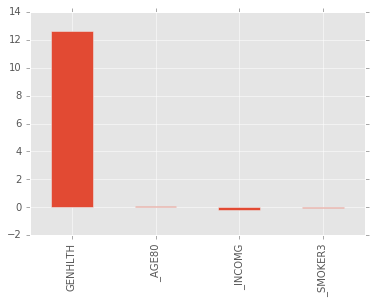

In [10]:
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = pd.Series(lr_clf.coef_[0],index=df_reduced.columns)
weights.plot(kind='bar')
plt.show()

At this point it would make sense to remove variables that are highly related to one another or ones that are irrelevant and keep going with the weights analysis.  
For this analysis, we will remove GENHLTH, which is what we're trying to predict, and have as the 'health' variable in a seperate dataframe.


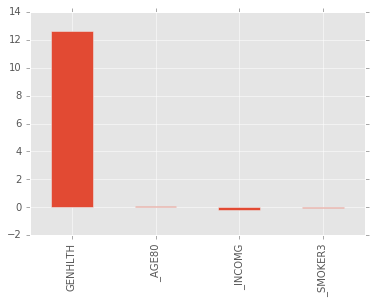

In [11]:

# you can also apply the StandardScaler function insied of the validation loop 
#  but this requires the use of PipeLines in scikit. Here is an example, but we will go over more 
#  thorough examples later in class

from sklearn.pipeline import Pipeline

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl), ('logit_model', lr_clf)])

# run the pipline crossvalidated
for iter_num, (train_indices, test_indices) in enumerate(cv_object):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    
# it is a little odd getting trained objects from a  pipeline:
trained_model_from_pipeline = piped_object.named_steps['logit_model']

# now look at the weights
weights = pd.Series(trained_model_from_pipeline.coef_[0],index=df_reduced.columns)
weights.plot(kind='bar')
plt.show()

## Support Vector Machine


In [12]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object: 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [13]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.05, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print "accuracy:", acc 
print conf

accuracy: 1.0
[[39280     0]
 [    0 36903]]


In [14]:
# look at the support vectors
print (svm_clf.support_vectors_.shape)
print (svm_clf.support_.shape)
print (svm_clf.n_support_) 

(96L, 4L)
(96L,)
[48 48]


[[  2.17309386e+00  -2.81025203e-16   2.23432384e-15  -9.57567359e-16]]


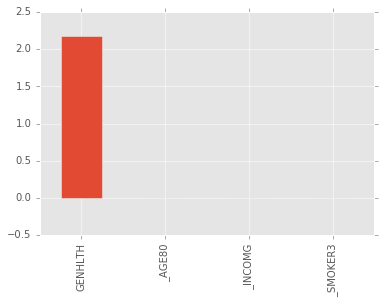

In [15]:
# if using linear kernel, these make sense to look at (not otherwise, why?)
print svm_clf.coef_
weights = pd.Series(svm_clf.coef_[0],index=df_reduced.columns)
weights.plot(kind='bar')

In [16]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)


# make a dataframe of the training data
df_tested_on = df_reduced.iloc[train_indices] # saved from above, the indices chosen for training
# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:]

df_support['health'] = y[svm_clf.support_] # add back in the 'health' Column to the pandas dataframe
df_reduced['health'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 202457 to 23522
Data columns (total 5 columns):
GENHLTH     96 non-null float64
_AGE80      96 non-null int64
_INCOMG     96 non-null float64
_SMOKER3    96 non-null float64
health      96 non-null category
dtypes: category(1), float64(3), int64(1)
memory usage: 3.9 KB


C:\Users\rahnl\Anaconda2\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


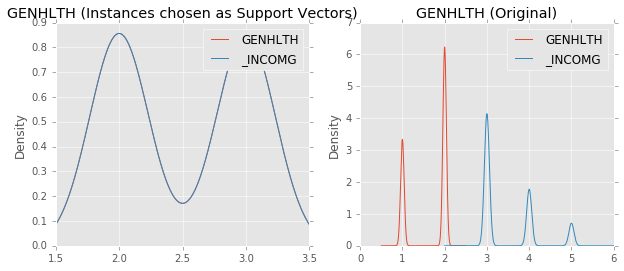

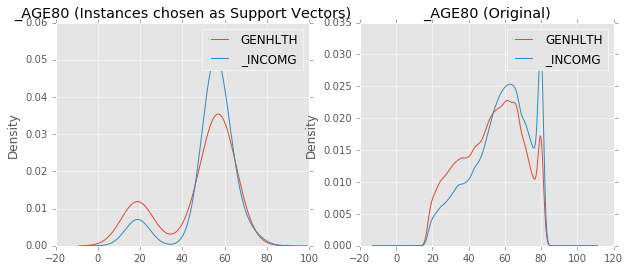

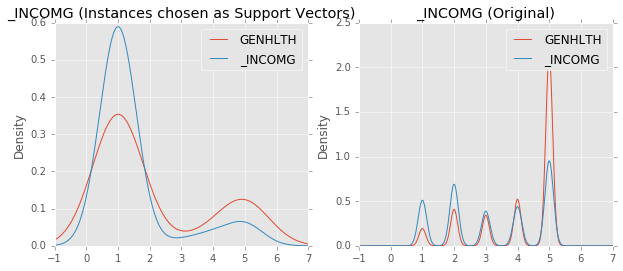

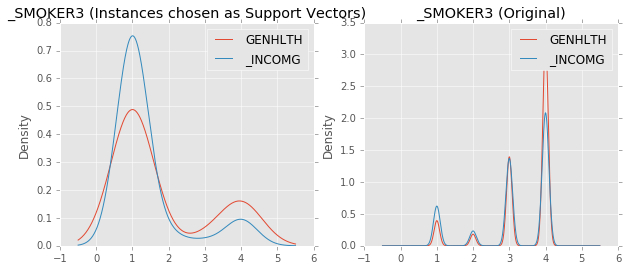

In [17]:
# now lets see the statistics of these attributes
from pandas.tools.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['health'])
df_grouped = df_reduced.groupby(['health'])

# plot KDE of Different variables
vars_to_plot = ['GENHLTH', '_AGE80', '_INCOMG','_SMOKER3']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['GENHLTH','_INCOMG'])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['GENHLTH','_INCOMG'])
    plt.title(v+' (Original)')

